In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image

## Load data

In [2]:
masks = glob.glob("../input/whales/*.png")
orgs = list(map(lambda x: x.replace(".png", ".jpg"), masks))

In [3]:
imgs_list = []
masks_list = []
for image, mask in zip(orgs, masks):
    imgs_list.append(np.array(Image.open(image).resize((384,384))))
    masks_list.append(np.array(Image.open(mask).resize((384,384))))

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)

In [4]:
print(imgs_np.shape, masks_np.shape)

(148, 384, 384, 3) (148, 384, 384)


## Plot images + masks + overlay (mask over original)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


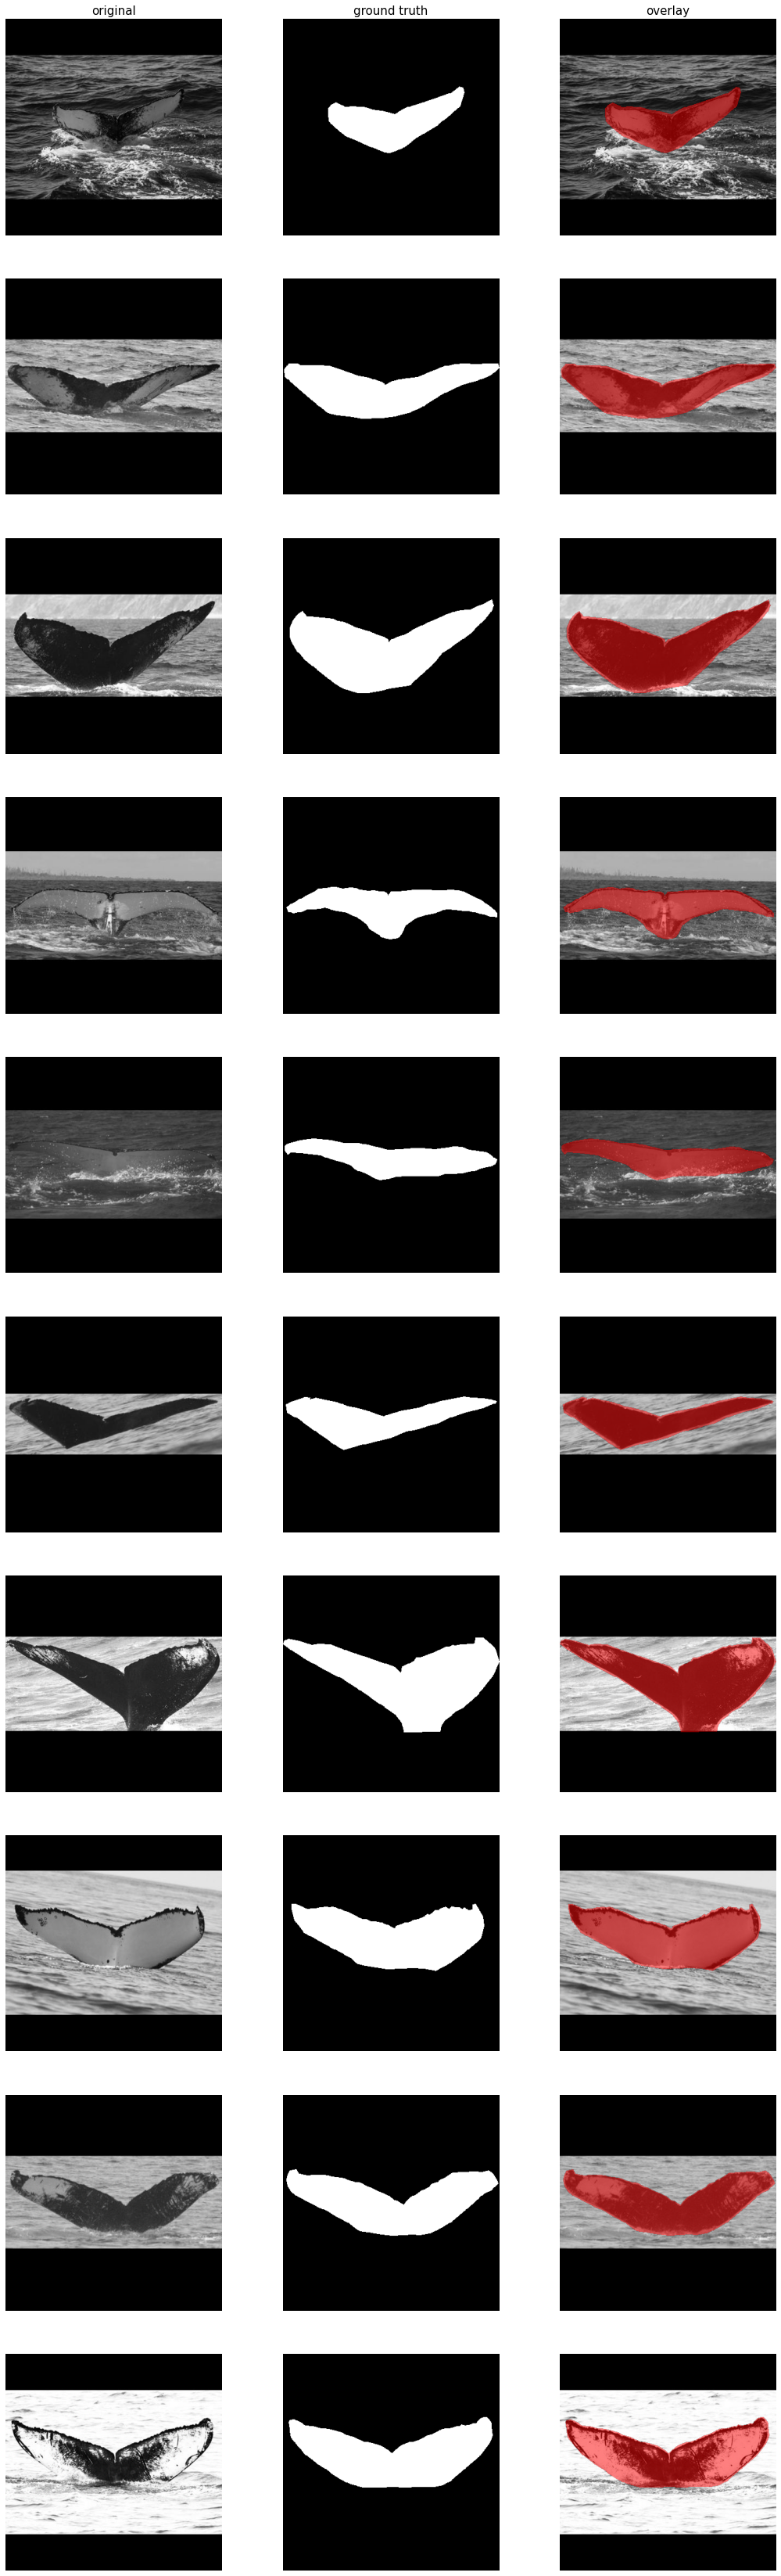

In [5]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=10, figsize=6)


## Get data into correct shape, dtype and range (0.0-1.0)

In [6]:
print(imgs_np.max(), masks_np.max())

255 1


In [7]:
x = np.asarray(imgs_np, dtype=np.float32)/255
y = np.asarray(masks_np, dtype=np.float32)

In [8]:
print(x.max(), y.max())

1.0 1.0


In [9]:
print(x.shape, y.shape)

(148, 384, 384, 3) (148, 384, 384)


In [10]:
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
print(x.shape, y.shape)

(148, 384, 384, 3) (148, 384, 384, 1)


##  Train/val split

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.9, random_state=0)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (14, 384, 384, 3)
y_train:  (14, 384, 384, 1)
x_val:  (134, 384, 384, 3)
y_val:  (134, 384, 384, 1)


## Prepare train generator with data augmentation

In [12]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant'
    ))

(2, 384, 384, 3) (2, 384, 384, 1)


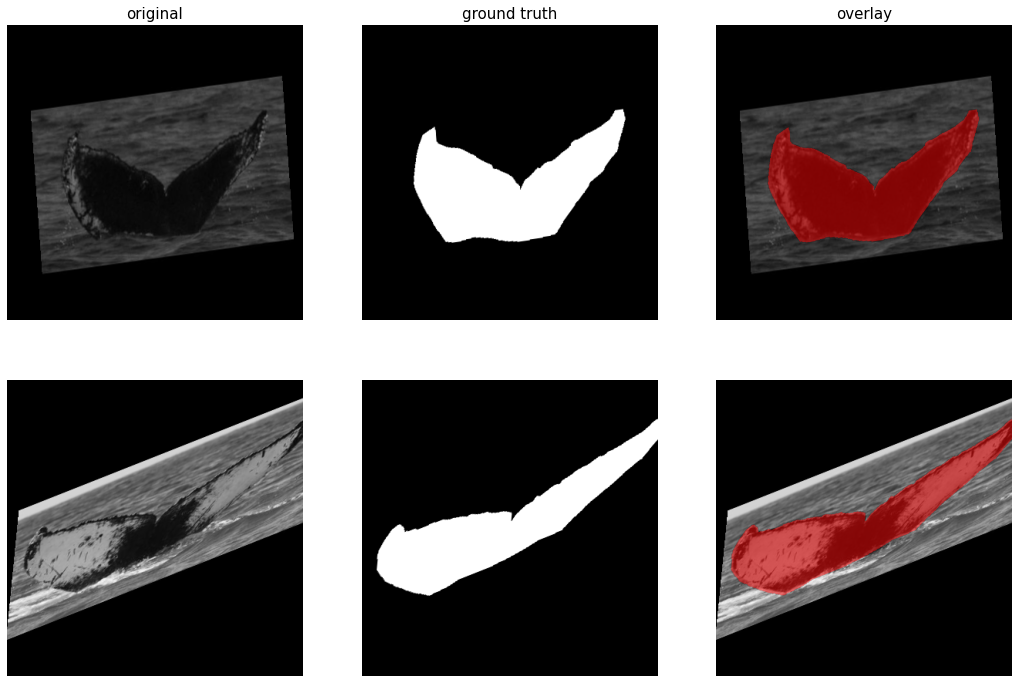

In [13]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

## Initialize network

In [14]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
    dropout_change_per_layer=0.0,
    num_layers=4
)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 384, 384, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 384, 384, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 384, 384, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Compile + train

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint


model_filename = 'segm_model_v3.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [17]:
from tensorflow.keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    optimizer=Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)


In [19]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=200,
    epochs=50,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

Instructions for updating:
Please use Model.fit, which supports generators.


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

## Plot training history

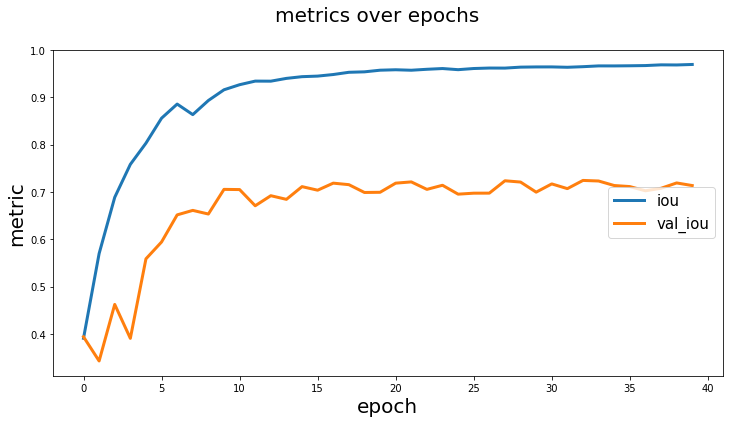

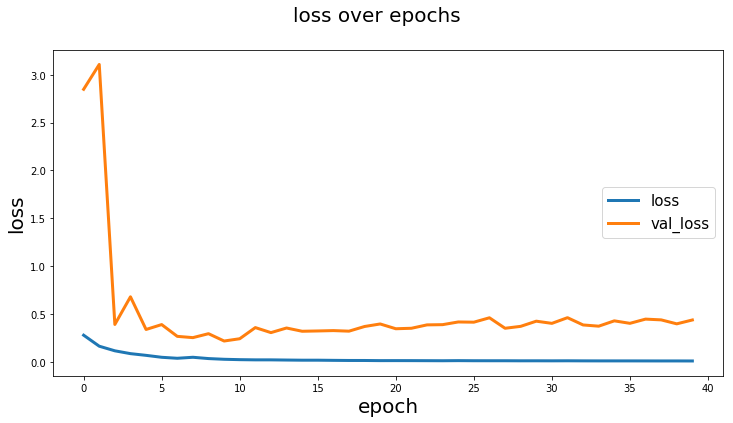

In [26]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

## Plot original + ground truth + pred + overlay (pred on top of original)

In [27]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)

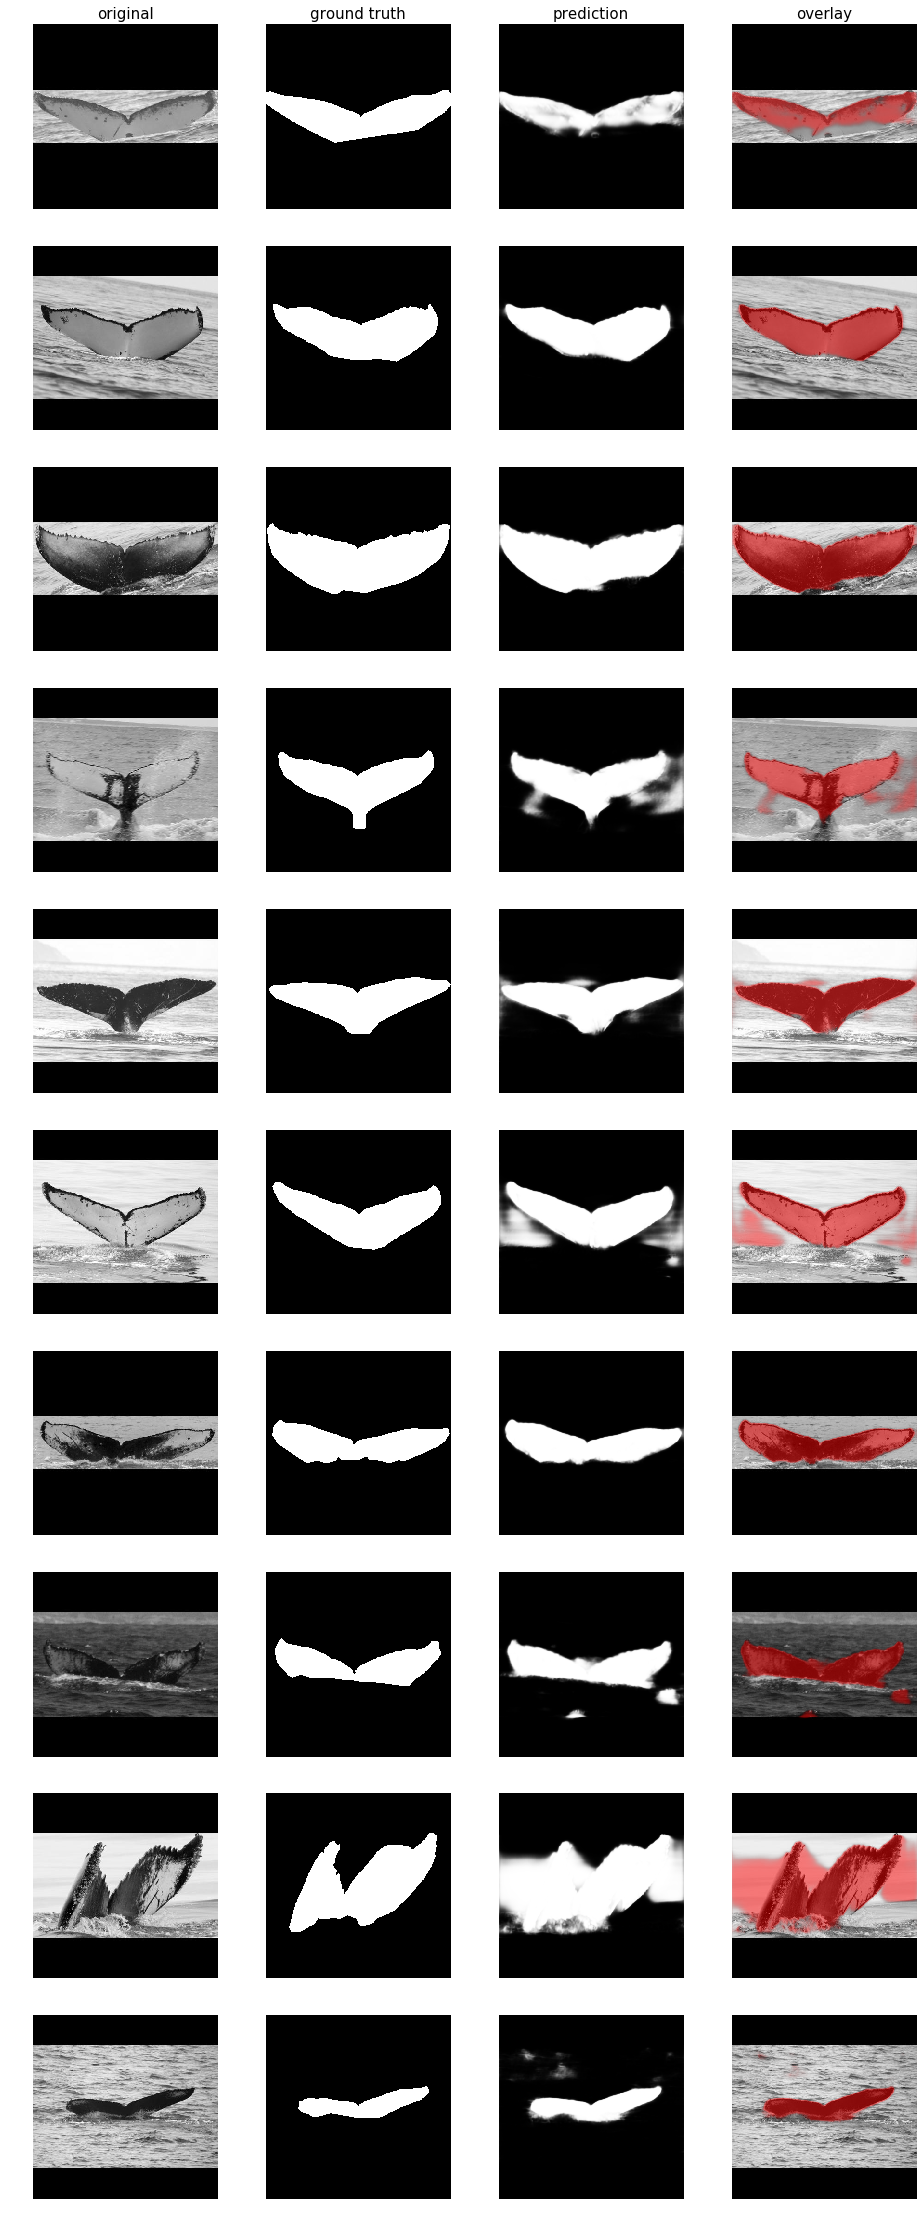

In [28]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)